In [ ]:
import sys
import os
from pathlib import Path
import pandas as pd

# Robustly find project root (looking for .git or src folder)
current_path = Path.cwd()
project_root = current_path
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

if not (project_root / "src").exists():
    # Fallback if we can't find it (e.g. new repo), assume we are in notebooks/
    project_root = Path.cwd().parent

src_path = project_root / "src"

# Add src to sys.path to allow importing pairs_trading_etf without installation
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Now we can import from our package
from pairs_trading_etf.data.ingestion import download_etf_data, save_raw_data, validate_price_data
from pairs_trading_etf.utils.config import load_yaml_config

CONFIG_PATH = project_root / "configs" / "data.yaml"
RAW_OUTPUT = project_root / "data" / "raw" / "etf_prices.csv"

print(f"Project root: {project_root}")
print(f"Loading config from: {CONFIG_PATH}")

config = load_yaml_config(CONFIG_PATH)
tickers = config["universe"]["etfs"]
date_cfg = config["data"]

print(f"Downloading data for {tickers} from {date_cfg['start_date']} to {date_cfg['end_date']}...")

prices = download_etf_data(
    tickers=tickers,
    start=date_cfg["start_date"],
    end=date_cfg["end_date"],
)

save_raw_data(prices, RAW_OUTPUT)
summary = validate_price_data(prices)

print(f"Downloaded price frame shape: {prices.shape}")
try:
    display(prices.head())
    display(summary)
except NameError:
    print(prices.head())
    print(summary)

NameError: name 'src_path' is not defined

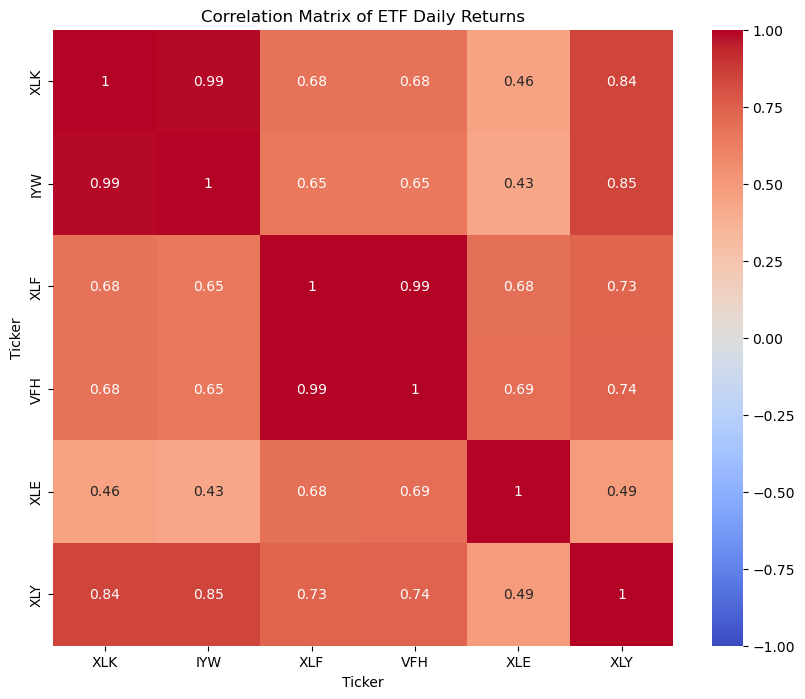

High correlation pairs (> 0.9):
XLF - VFH: 0.9934
XLK - IYW: 0.9876


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix of returns (not prices!)
# We use returns because prices are non-stationary
returns = prices.pct_change().dropna()
corr_matrix = returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of ETF Daily Returns')
plt.show()

# Identify high correlation pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        ticker1 = corr_matrix.columns[i]
        ticker2 = corr_matrix.columns[j]
        corr = corr_matrix.iloc[i, j]
        if corr > 0.9: # Threshold for "high" correlation
            high_corr_pairs.append((ticker1, ticker2, corr))

print("High correlation pairs (> 0.9):")
for p in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
    print(f"{p[0]} - {p[1]}: {p[2]:.4f}")

## Next steps
- [ ] Compute correlation matrix & visualize via heatmap.
- [ ] Run rolling correlation to identify stable relationships.
- [ ] Implement Engle–Granger two-step test for top candidate pairs.
- [ ] Validate cointegration hits with Johansen test (if multivariate).

In [2]:
# Rolling correlation analysis for the top pair
# This helps check if the relationship is stable over time or just a temporary regime

if high_corr_pairs:
    # Pick the pair with the highest correlation
    top_pair = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[0]
    t1, t2, _ = top_pair
    
    window = 126 # Approx 6 months of trading days
    rolling_corr = returns[t1].rolling(window=window).corr(returns[t2])
    
    plt.figure(figsize=(12, 6))
    rolling_corr.plot(title=f'{window}-Day Rolling Correlation: {t1} vs {t2}')
    plt.axhline(rolling_corr.mean(), color='r', linestyle='--', label='Mean Correlation')
    plt.legend()
    plt.ylabel('Correlation')
    plt.show()
else:
    print("No high correlation pairs found to analyze.")

NameError: name 'high_corr_pairs' is not defined